In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")

In [53]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","reference_price"]


In [75]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        filings["year"] = [x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        ticker_factors = filings.drop(["date","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
        ticker_factors["ticker"] = ticker
        ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
        ticker_factors["y"] = ticker_factors["adjclose"]
        factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

27it [00:01, 19.84it/s]

AMTM 'date'


63it [00:03, 16.34it/s]

BRK.B 'date'


67it [00:04, 16.80it/s]

BLK 'date'


78it [00:04, 19.21it/s]

BF.B 'date'


502it [00:29, 17.04it/s]

ZTS 'date'


In [76]:
factors_df.sort_values(["ticker","year","quarter"])

,year,quarter,ticker,adjclose,y,assets,liabilities,reference_price
0,2014,1,A,37.984034,37.984034,1.059450e+10,5.326500e+09,NaN
1,2014,2,A,37.120989,37.120989,1.056150e+10,5.315000e+09,37.984034
2,2014,3,A,37.846924,37.846924,1.040700e+10,5.419500e+09,37.120989
3,2014,4,A,37.250024,37.250024,1.061100e+10,5.374000e+09,37.846924
4,2015,1,A,37.340297,37.340297,1.066200e+10,5.294000e+09,37.250024
...,...,...,...,...,...,...,...,...
42,2024,3,ZBRA,335.879531,335.879531,7.492500e+09,4.630000e+09,304.088016
43,2024,4,ZBRA,387.112069,387.112069,7.430000e+09,4.557000e+09,335.879531
44,2025,1,ZBRA,NaN,NaN,7.417500e+09,4.533000e+09,387.112069
45,2025,2,ZBRA,NaN,NaN,7.282500e+09,4.180000e+09,NaN


In [77]:
model = XGBRegressor()
training_data = factors_df[(factors_df["year"]>=2013) & (factors_df["year"]<2020)].dropna()
sim = factors_df[(factors_df["year"]>=2019)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["year","quarter","ticker","prediction"]]

In [78]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|███████████████████████▎                                                                                                                                                                     | 62/502 [00:03<00:20, 21.73it/s]

'date'


 16%|█████████████████████████████▎                                                                                                                                                               | 78/502 [00:03<00:20, 21.18it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:26<00:00, 18.84it/s]

'date'


In [79]:
simulation = pd.concat(prices).dropna()

In [80]:
tickers = list(simulation[simulation["year"]==2020]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

In [81]:
simulation["factor"] = simulation["prediction"]/simulation["adjclose"] - 1

In [82]:
simulation["rank"] = simulation.groupby(["date"])["factor"].rank(method="dense",ascending=False).astype(int)

In [83]:
simulation["exposure"] = [1 if x <= simulation["rank"].max() * 0.50 else -1 if x > simulation["rank"].max() * 0.50 else 1.0/6.0 for x in simulation["rank"]]

In [84]:
weight = 1 / len(tickers)

In [85]:
simulation["sell_price"] = simulation["adjclose"]
simulation.sort_values("date",inplace=True)
trades = simulation[simulation["year"]>=2020][["year","quarter","ticker","exposure","adjclose","sell_price"]].groupby(["year","quarter","ticker"]).agg({"exposure":"first","adjclose":"first","sell_price":"last"}).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * weight
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).sum().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()

In [86]:
trades.sort_values("return",ascending=False).head(40)

,year,quarter,ticker,exposure,adjclose,sell_price,return
5409,2024,1,SMCI,1,28.545000,101.003000,0.007623
389,2020,2,CZR,1,11.690000,40.060000,0.007288
597,2020,2,TSLA,1,32.104000,71.987333,0.003731
442,2020,2,HAL,1,6.151865,12.141571,0.002924
1235,2020,4,TPR,1,14.276826,27.907155,0.002867
558,2020,2,RCL,1,25.710911,50.184666,0.002859
4148,2023,1,TSLA,1,108.100000,207.460000,0.002760
5365,2024,1,NVDA,1,48.152736,90.331571,0.002630
5453,2024,1,VST,1,37.711368,69.226814,0.002510
422,2020,2,FCX,1,6.033135,11.062341,0.002503


In [87]:
trades.iloc[-505:].to_csv("current.csv")

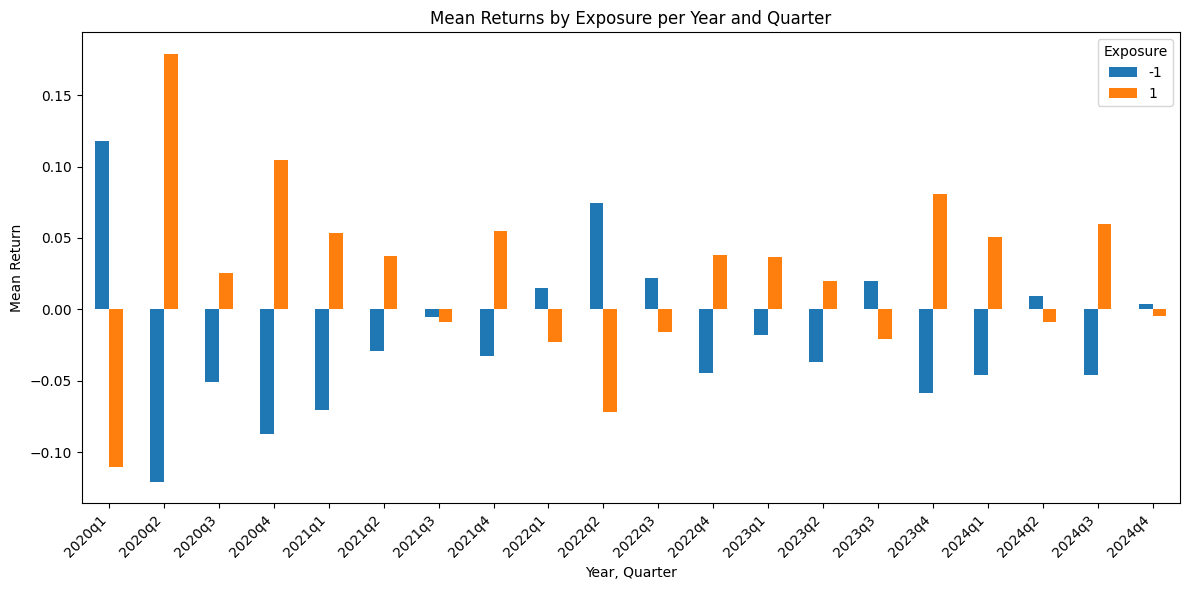

In [88]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


In [89]:
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).sum().reset_index()
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1

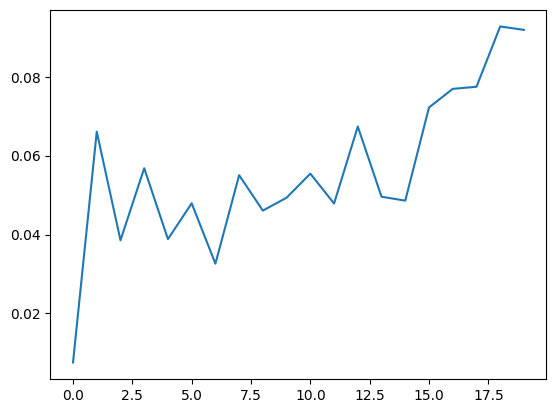

In [90]:
plt.plot(portfolio.index,portfolio["return"])

In [91]:
trades.merge(index,on=["ticker"],how="left")[["year","quarter","GICS Sector","return"]].groupby(["year","quarter","GICS Sector"]).sum().tail(20)

return
year quarter GICS Sector                     
2024 3       Consumer Staples        0.000049
             Energy                 -0.000938
             Financials              0.001130
             Health Care             0.003129
             Industrials             0.008973
             Information Technology  0.002300
             Materials               0.001807
             Real Estate            -0.007130
             Utilities               0.000328
     4       Communication Services  0.001341
             Consumer Discretionary  0.002513
             Consumer Staples       -0.001165
             Energy                 -0.002125
             Financials              0.000328
             Health Care            -0.000372
             Industrials            -0.001596
             Information Technology -0.001893
             Materials               0.002178
             Real Estate             0.000191
             Utilities              -0.000186

In [92]:
sim[sim["year"]==2025].head(20)

,year,quarter,ticker,prediction
44,2025,1,MMM,134.149841
44,2025,1,AOS,77.228142
33,2025,1,ADBE,1441.628906
44,2025,1,AFL,111.016563
44,2025,1,A,144.555984
44,2025,1,APD,307.646942
11,2025,1,ABNB,141.447952
44,2025,1,AKAM,100.080620
43,2025,1,ARE,112.096489
44,2025,1,ALGN,235.530365
